#Tidy Tuesday - Shakespeare

In [1]:
import polars as pl

hamlet = pl.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/refs/heads/main/data/2024/2024-09-17/hamlet.csv')

In [2]:
print(hamlet)

shape: (4_217, 5)
┌───────┬──────────┬───────────────────┬─────────────────────────────────┬─────────────┐
│ act   ┆ scene    ┆ character         ┆ dialogue                        ┆ line_number │
│ ---   ┆ ---      ┆ ---               ┆ ---                             ┆ ---         │
│ str   ┆ str      ┆ str               ┆ str                             ┆ str         │
╞═══════╪══════════╪═══════════════════╪═════════════════════════════════╪═════════════╡
│ Act I ┆ Scene I  ┆ [stage direction] ┆ FRANCISCO at his post. Enter t… ┆ NA          │
│ Act I ┆ Scene I  ┆ Bernardo          ┆ Who's there?                    ┆ 1           │
│ Act I ┆ Scene I  ┆ Francisco         ┆ Nay, answer me: stand, and unf… ┆ 2           │
│ Act I ┆ Scene I  ┆ Bernardo          ┆ Long live the king!             ┆ 3           │
│ Act I ┆ Scene I  ┆ Francisco         ┆ Bernardo?                       ┆ 4           │
│ …     ┆ …        ┆ …                 ┆ …                               ┆ …           │
│ A

In [3]:
# characters can have multiple lines of dialogue

hamlet1 = (
    hamlet
    # remove stage direction lines
    .filter(pl.col('character') != '[stage direction]')
    # create an ID for dialogue that resets when there's a new character
    # (to group together dialogue lines)
    .with_columns(character_change = pl.when(pl.col('character').shift(-1) != pl.col('character')).then(1).otherwise(0))
    # do a cumulative sum - this results in a unique ID for each dialogue character bit
    .with_columns(dialogue_id = pl.cum_sum('character_change'))
)

print(hamlet1)

shape: (4_011, 7)
┌───────┬──────────┬────────────┬───────────────────┬─────────────┬──────────────────┬─────────────┐
│ act   ┆ scene    ┆ character  ┆ dialogue          ┆ line_number ┆ character_change ┆ dialogue_id │
│ ---   ┆ ---      ┆ ---        ┆ ---               ┆ ---         ┆ ---              ┆ ---         │
│ str   ┆ str      ┆ str        ┆ str               ┆ str         ┆ i32              ┆ i32         │
╞═══════╪══════════╪════════════╪═══════════════════╪═════════════╪══════════════════╪═════════════╡
│ Act I ┆ Scene I  ┆ Bernardo   ┆ Who's there?      ┆ 1           ┆ 1                ┆ 1           │
│ Act I ┆ Scene I  ┆ Francisco  ┆ Nay, answer me:   ┆ 2           ┆ 1                ┆ 2           │
│       ┆          ┆            ┆ stand, and unf…   ┆             ┆                  ┆             │
│ Act I ┆ Scene I  ┆ Bernardo   ┆ Long live the     ┆ 3           ┆ 1                ┆ 3           │
│       ┆          ┆            ┆ king!             ┆             ┆      

In [4]:
# how we'd do this in pandas

# group each piece of dialogue together, instead of lines

#hamlet1 = hamlet.loc[hamlet['character'] != '[stage direction]'] # remove stage direction

# whenever the character changes return 1

#hamlet1['dialogue_change'] = (hamlet1['character'] != hamlet1['character'].shift()).astype(int)

#hamlet1['dialogue_id'] = hamlet1['dialogue_change'].cumsum()

#hamlet1.head()

In [5]:
# now pull together all dialogue under the same id, and truncate to 512 characters

hamlet2 = (
    hamlet1
    .group_by(['act', 'scene', 'character', 'dialogue_id']).agg(
      pl.col('dialogue').str.join(''),
      pl.col('line_number').min().alias('from_line'),
      pl.col('line_number').max().alias('to_line')
      )
    .with_columns(dialogue_s = pl.col('dialogue').str.slice(offset = 0, length = 512))
    .sort('dialogue_id')
)

print(hamlet2)

shape: (1_673, 8)
┌───────┬──────────┬──────────────┬─────────────┬──────────────┬───────────┬─────────┬─────────────┐
│ act   ┆ scene    ┆ character    ┆ dialogue_id ┆ dialogue     ┆ from_line ┆ to_line ┆ dialogue_s  │
│ ---   ┆ ---      ┆ ---          ┆ ---         ┆ ---          ┆ ---       ┆ ---     ┆ ---         │
│ str   ┆ str      ┆ str          ┆ i32         ┆ str          ┆ str       ┆ str     ┆ str         │
╞═══════╪══════════╪══════════════╪═════════════╪══════════════╪═══════════╪═════════╪═════════════╡
│ Act I ┆ Scene I  ┆ Bernardo     ┆ 1           ┆ Who's there? ┆ 1         ┆ 1       ┆ Who's       │
│       ┆          ┆              ┆             ┆              ┆           ┆         ┆ there?      │
│ Act I ┆ Scene I  ┆ Francisco    ┆ 2           ┆ Nay, answer  ┆ 2         ┆ 2       ┆ Nay, answer │
│       ┆          ┆              ┆             ┆ me: stand,   ┆           ┆         ┆ me: stand,  │
│       ┆          ┆              ┆             ┆ and unf…     ┆         

In [6]:
# pandas

# dialogue can be short - pull together using dialogue id

#hamlet1 = hamlet1.groupby(['act', 'scene', 'character', 'dialogue_id']).agg({'dialogue': ' '.join, 'line_number': ['min', 'max']})

#hamlet1['chars'] = hamlet1['dialogue'].astype(str).str.len()

#hamlet1 = pd.DataFrame(hamlet1.to_records()) # collapse multi-index

# rename columns
#hamlet1 = hamlet1.rename(columns = {hamlet1.columns[4]: 'dialogue', hamlet1.columns[5]: 'from_line', hamlet1.columns[6]: 'to_line'}, errors = 'raise')

# truncate string to 512 characters
#hamlet1['dialogue_s'] = hamlet1['dialogue'].str.slice(0, 520)

#hamlet1.head(25)

## Sentiment Analysis

In [7]:
from transformers import pipeline
sentiment_task = pipeline("sentiment-analysis")
sentiment_task("O, that this too, too solid flesh would melt, Thaw and resolve itself into a dew!")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


[{'label': 'NEGATIVE', 'score': 0.9981605410575867}]

In [8]:
# get a small sample - use rows to convert to a list
# but each list has an extra comma - does that matter?

head = hamlet2.head().select('dialogue').rows()

head

[("Who's there?",),
 ('Nay, answer me: stand, and unfold yourself.',),
 ('Long live the king!',),
 ('Bernardo?',),
 ('He.',)]

In [9]:
head_sent = sentiment_task(head)

head_sent

[{'label': 'NEGATIVE', 'score': 0.9892655611038208},
 {'label': 'NEGATIVE', 'score': 0.7604517340660095},
 {'label': 'POSITIVE', 'score': 0.9993764758110046},
 {'label': 'NEGATIVE', 'score': 0.9618363976478577},
 {'label': 'POSITIVE', 'score': 0.9735297560691833}]

In [10]:
#pd.DataFrame.from_dict(head_sent) # from dictionary -> dataframe

print(pl.DataFrame(head_sent))

shape: (5, 2)
┌──────────┬──────────┐
│ label    ┆ score    │
│ ---      ┆ ---      │
│ str      ┆ f64      │
╞══════════╪══════════╡
│ NEGATIVE ┆ 0.989266 │
│ NEGATIVE ┆ 0.760452 │
│ POSITIVE ┆ 0.999376 │
│ NEGATIVE ┆ 0.961836 │
│ POSITIVE ┆ 0.97353  │
└──────────┴──────────┘


In [11]:
all_sent = sentiment_task(hamlet2.select('dialogue_s').rows()) # only ~2 minutes to do all of Hamlet dialogue

In [12]:
all_sent_df = pl.DataFrame(all_sent) #pd.DataFrame.from_dict(all_sent)

all_sent_df.head()

label,score
str,f64
"""NEGATIVE""",0.989266
"""NEGATIVE""",0.760452
"""POSITIVE""",0.999376
"""NEGATIVE""",0.961836
"""POSITIVE""",0.97353


In [13]:
# polars dataframes don't have an index, unlike pandas, so we can use a concat
# at the df level to join without an index

hamlet2 = pl.concat([hamlet2, all_sent_df], how = 'horizontal') #pd.merge(hamlet1, all_sent_df, left_index = True, right_index = True)

hamlet2.head(n = 10)

act,scene,character,dialogue_id,dialogue,from_line,to_line,dialogue_s,label,score
str,str,str,i32,str,str,str,str,str,f64
"""Act I""","""Scene I""","""Bernardo""",1,"""Who's there?""","""1""","""1""","""Who's there?""","""NEGATIVE""",0.989266
"""Act I""","""Scene I""","""Francisco""",2,"""Nay, answer me: stand, and unf…","""2""","""2""","""Nay, answer me: stand, and unf…","""NEGATIVE""",0.760452
"""Act I""","""Scene I""","""Bernardo""",3,"""Long live the king!""","""3""","""3""","""Long live the king!""","""POSITIVE""",0.999376
"""Act I""","""Scene I""","""Francisco""",4,"""Bernardo?""","""4""","""4""","""Bernardo?""","""NEGATIVE""",0.961836
"""Act I""","""Scene I""","""Bernardo""",5,"""He.""","""5""","""5""","""He.""","""POSITIVE""",0.97353
"""Act I""","""Scene I""","""Francisco""",6,"""You come most carefully upon y…","""6""","""6""","""You come most carefully upon y…","""POSITIVE""",0.98735
"""Act I""","""Scene I""","""Bernardo""",7,"""'Tis now struck twelve; get th…","""7""","""7""","""'Tis now struck twelve; get th…","""NEGATIVE""",0.972015
"""Act I""","""Scene I""","""Francisco""",7,"""For this relief much thanks: '…","""8""","""8""","""For this relief much thanks: '…","""POSITIVE""",0.996258
"""Act I""","""Scene I""","""Francisco""",8,"""And I am sick at heart.""","""9""","""9""","""And I am sick at heart.""","""NEGATIVE""",0.999427


In [14]:
sent_counts = hamlet2.group_by(['character', 'label']).len(name = 'count')

sent_counts

character,label,count
str,str,u32
"""First Ambassador""","""NEGATIVE""",2
"""Voltimand""","""NEGATIVE""",2
"""Prince Fortinbras""","""NEGATIVE""",4
"""Player King""","""NEGATIVE""",6
"""Bernardo""","""NEGATIVE""",19
…,…,…
"""Ophelia""","""POSITIVE""",47
"""Marcellus""","""POSITIVE""",16
"""King Claudius""","""NEGATIVE""",89


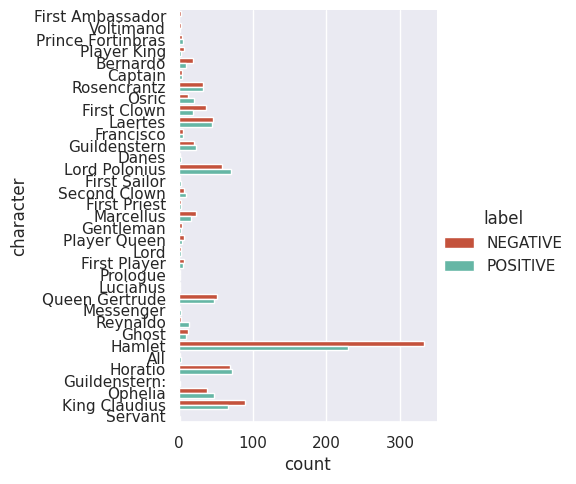

In [15]:
import seaborn as sns
sns.set_theme()

colors = sns.color_palette(['#db4325', '#57c4ad'], 2)

sns.catplot(data = sent_counts, kind = 'bar', y = 'character', x = 'count', hue = 'label', palette = colors)

In [16]:
hamlet2.filter(pl.col('label') == 'POSITIVE').sort('score', descending = True).select(['character', 'dialogue', 'label', 'score'])

#hamlet2.loc[hamlet2['label'] == 'POSITIVE'].sort_values(by = ['score'], ascending = False)

character,dialogue,label,score
str,str,str,f64
"""Laertes""","""And gem of all the nation.""","""POSITIVE""",0.999888
"""Horatio""","""This marvel to you.""","""POSITIVE""",0.999885
"""Hamlet""","""O, wonderful!""","""POSITIVE""",0.99988
"""Hamlet""","""In happy time.""","""POSITIVE""",0.999879
"""Guildenstern""","""Pleasant and helpful to him!""","""POSITIVE""",0.999878
…,…,…,…
"""Hamlet""","""I do not think so: since he we…","""POSITIVE""",0.522865
"""Queen Gertrude""","""This the very coinage of your …","""POSITIVE""",0.521289
"""Hamlet""","""The Mouse-trap. Marry, how? Tr…","""POSITIVE""",0.515482


In [17]:
hamlet2.filter(pl.col('label') == 'POSITIVE').sort('score', descending = False).select(['character', 'dialogue', 'label', 'score'])

#hamlet2.loc[hamlet2['label'] == 'NEGATIVE'].sort_values(by = ['score'], ascending = False)

character,dialogue,label,score
str,str,str,f64
"""First Priest""","""Of bell and burial.""","""POSITIVE""",0.508171
"""Hamlet""","""'Tis well: I'll have thee spea…","""POSITIVE""",0.509288
"""Hamlet""","""The Mouse-trap. Marry, how? Tr…","""POSITIVE""",0.515482
"""Queen Gertrude""","""This the very coinage of your …","""POSITIVE""",0.521289
"""Hamlet""","""I do not think so: since he we…","""POSITIVE""",0.522865
…,…,…,…
"""Guildenstern""","""Pleasant and helpful to him!""","""POSITIVE""",0.999878
"""Hamlet""","""In happy time.""","""POSITIVE""",0.999879
"""Hamlet""","""O, wonderful!""","""POSITIVE""",0.99988


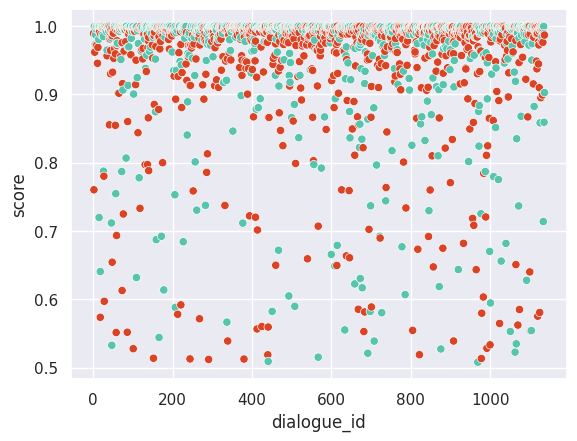

In [18]:
ax = sns.scatterplot(data = hamlet2, x = 'dialogue_id', y = 'score', hue = 'label', palette = colors)

ax.get_legend().remove()

# score isn't really helpful - just shows the dubiously categorized lines

<Axes: xlabel='dialogue_id', ylabel='score3'>

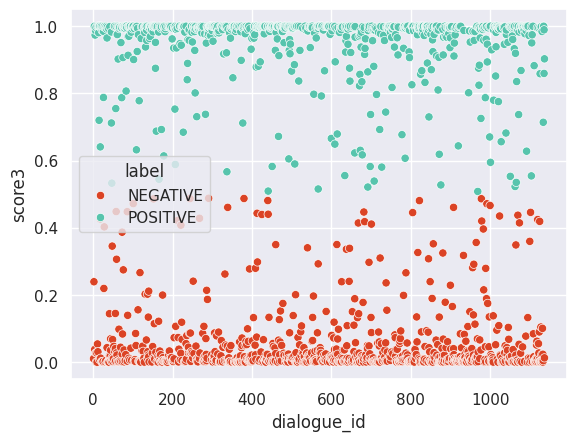

In [21]:
# try a score that explains direction and confidence

hamlet2 = (
    hamlet2
    .with_columns(score2 = pl.when(pl.col('label') == 'NEGATIVE').then(-1).otherwise(1) * pl.col('score') )
    .with_columns(score3 = pl.when(pl.col('score2') < 0).then(pl.col('score2') + 1).otherwise(pl.col('score2')))
    )

sns.scatterplot(data = hamlet2, x = 'dialogue_id', y = 'score3', hue = 'label', palette = colors)

<Axes: xlabel='dialogue_id', ylabel='score3'>

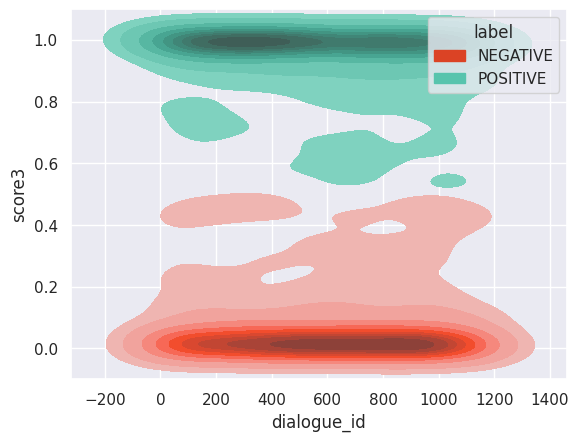

In [22]:
sns.kdeplot(data = hamlet2, x = 'dialogue_id', y = 'score3', fill = True, hue = 'label', palette = colors)

<Axes: xlabel='dialogue_id', ylabel='Density'>

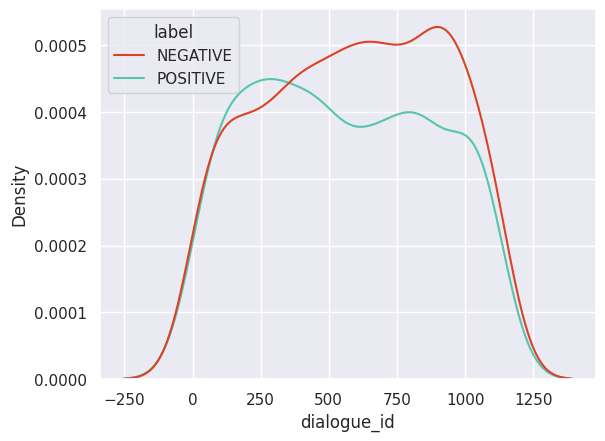

In [23]:
sns.kdeplot(data = hamlet2, x = 'dialogue_id', hue = 'label', palette = colors)

<Axes: xlabel='dialogue_id', ylabel='Density'>

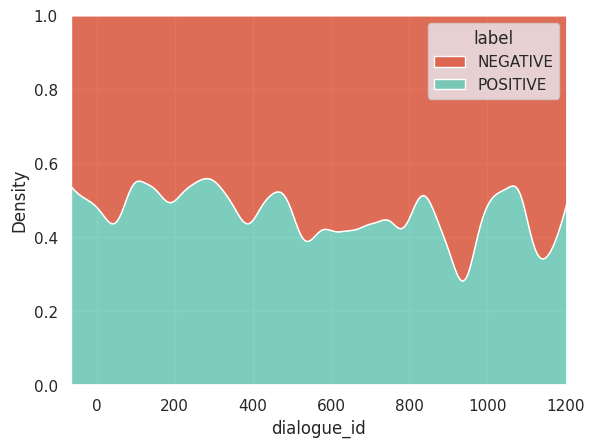

In [24]:
sns.kdeplot(data = hamlet2, x = 'dialogue_id', hue = 'label', palette = colors, multiple = 'fill', bw_adjust = .3)
# using the dialogue id as a time indicator

In [25]:
time = hamlet2.group_by(['act', 'scene', 'label']).len(name = 'count')
#time = hamlet2.groupby(['act', 'scene'])['label'].value_counts().to_frame()

time

act,scene,label,count
str,str,str,u32
"""Act III""","""Scene IV""","""NEGATIVE""",49
"""Act IV""","""Scene VI""","""POSITIVE""",6
"""Act III""","""Scene II""","""POSITIVE""",80
"""Act I""","""Scene IV""","""POSITIVE""",16
"""Act II""","""Scene II""","""POSITIVE""",125
…,…,…,…
"""Act III""","""Scene II""","""NEGATIVE""",118
"""Act IV""","""Scene I""","""NEGATIVE""",6
"""Act I""","""Scene IV""","""NEGATIVE""",23


<Axes: xlabel='act', ylabel='count'>

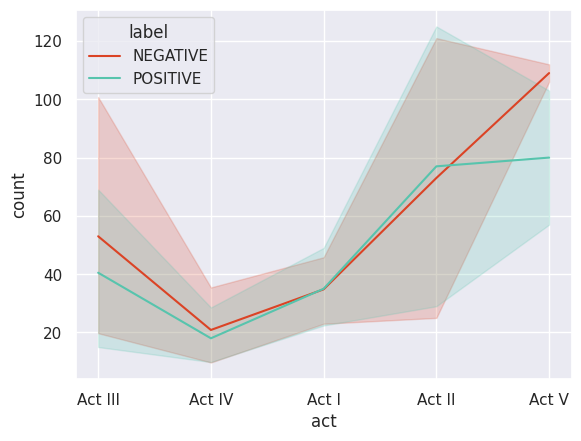

In [26]:
sns.lineplot(data = time, x = 'act', y = 'count', hue = 'label', palette = colors)

## Zero shot classification

In [27]:
classifier = pipeline("zero-shot-classification",
                      model="facebook/bart-large-mnli")

config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cpu


In [28]:
head = hamlet2.sample(5).select('dialogue').rows()

head

[('This the very coinage of your brain:This bodiless creation ecstasy',),
 ('and boy, thirty years.',),
 ("His purse is empty already; all's golden words are spent.",),
 ('spacious in the possession of dirt.',),
 ('Ay, sir; to be honest, as this world goes, is to be',)]

In [29]:
# create labels that are more readable by a classifier and generation alpha slang dictionary

candidate_labels = ['charisma', 'awesome or cool', 'surprise', 'leadership or self-sufficiency', 'style', 'suspicious']

alpha = {
    'charisma': 'rizz',
    'awesome or cool': 'skibidi',
    'surprise': 'GYAT',
    'leadership or self-sufficiency': 'sigma',
    'style': 'drip',
    'suspicious': 'sus'
}

In [30]:
head_zc = pl.DataFrame(classifier(head, candidate_labels)).explode(['labels', 'scores'])

print(head_zc)

shape: (30, 3)
┌─────────────────────────────────┬────────────────────────────────┬──────────┐
│ sequence                        ┆ labels                         ┆ scores   │
│ ---                             ┆ ---                            ┆ ---      │
│ str                             ┆ str                            ┆ f64      │
╞═════════════════════════════════╪════════════════════════════════╪══════════╡
│ This the very coinage of your … ┆ awesome or cool                ┆ 0.844403 │
│ This the very coinage of your … ┆ surprise                       ┆ 0.06327  │
│ This the very coinage of your … ┆ style                          ┆ 0.049838 │
│ This the very coinage of your … ┆ leadership or self-sufficiency ┆ 0.017685 │
│ This the very coinage of your … ┆ charisma                       ┆ 0.014394 │
│ …                               ┆ …                              ┆ …        │
│ Ay, sir; to be honest, as this… ┆ awesome or cool                ┆ 0.224886 │
│ Ay, sir; to be honest, 

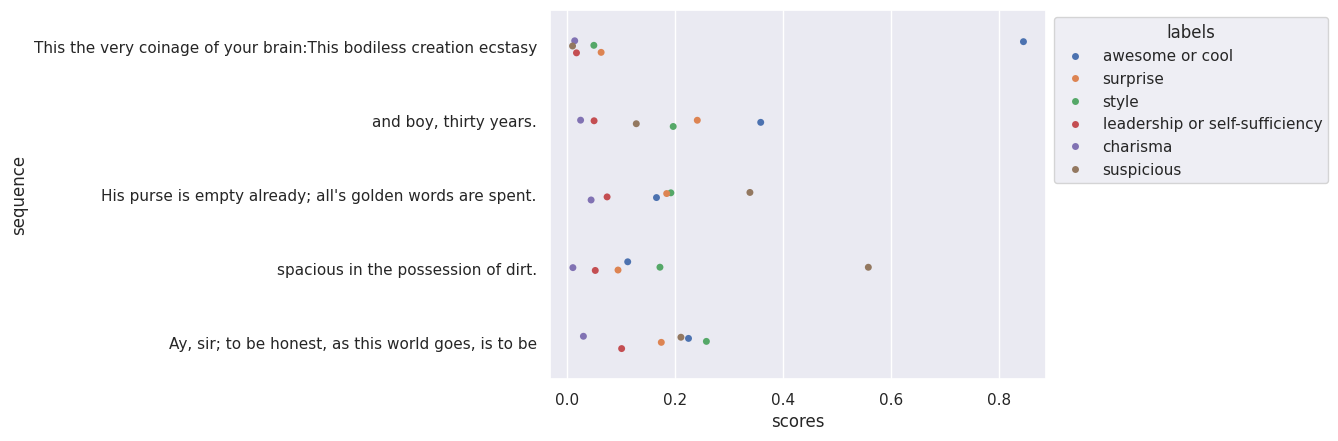

In [31]:
ax = sns.stripplot(head_zc, x = 'scores', y = 'sequence', hue = 'labels')

sns.move_legend(ax, 'upper left', bbox_to_anchor = (1, 1))

In [32]:
# takes a while, try for just Hamlet

hamlet_d = hamlet2.filter(pl.col('character') == 'Hamlet').select('dialogue_s').rows()

len(hamlet_d)

562

In [33]:
zc = pl.DataFrame(classifier(hamlet_d, candidate_labels)).explode(['labels', 'scores'])

KeyboardInterrupt: 

In [ ]:
# like above this is going to result in one row per potential label
# join on dialogue since it's one to many

hamlet3 = hamlet2.join(zc, left_on = 'dialogue', right_on = 'sequence', how = 'right')

#pd.merge(hamlet1, all_sent_df, left_index = True, right_index = True)

print(hamlet3)

In [ ]:
# join slang

alpha_df = pl.DataFrame({
    'keys': list(alpha.keys()),
    'slang': list(alpha.values())
})

hamlet3 = hamlet3.join(alpha_df, right_on = 'keys', left_on = 'labels')

hamlet3

In [35]:
# takes a while to calculate probs, save to Drive
from google.colab import drive
drive.mount('/content/drive')

#hamlet3.write_csv('/content/drive/My Drive/Data/hamlet_data.csv')

hamlet3 = pl.read_csv('/content/drive/My Drive/Data/hamlet_data.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
hamlet3.sort('scores', descending = True).select(['dialogue_s', 'labels', 'scores'])

dialogue_s,labels,scores
str,str,f64
"""What warlike noise is this?""","""suspicious""",0.942915
"""Treachery! Seek it out.""","""suspicious""",0.938025
"""This physic but prolongs thy s…","""suspicious""",0.931865
"""In further evil?""","""suspicious""",0.92255
"""But he's an arrant knave.""","""suspicious""",0.893767
…,…,…
"""What warlike noise is this?""","""charisma""",0.002094
"""Treachery! Seek it out.""","""leadership or self-sufficiency""",0.002033
"""Murder of Gonzago?""","""charisma""",0.001828


In [37]:
# get the highest probability per line of dialogue

hamlet4 = (
    hamlet3
    .group_by('dialogue_s').agg(
        pl.all().sort_by('scores', descending = True).first()
    )
)

# see top for each category
hamlet4.group_by('slang').agg(pl.all().sort_by('scores', descending = True).first()).select(['slang', 'labels', 'sequence', 'scores'])

slang,labels,sequence,scores
str,str,str,f64
"""drip""","""style""","""Gentlemen, you are welcome to …",0.817741
"""sigma""","""leadership or self-sufficiency""","""Horatio, thou art e'en as just…",0.756456
"""rizz""","""charisma""","""O villany! Ho! let the door be…",0.384032
"""skibidi""","""awesome or cool""","""Another hit; what say you?""",0.860066
"""sus""","""suspicious""","""What warlike noise is this?""",0.942915
"""GYAT""","""surprise""","""What?""",0.625862


In [38]:
hamlet4.filter(pl.col('act').is_null())

dialogue_s,act,scene,character,dialogue_id,from_line,to_line,label,score,score2,score3,sequence,labels,scores,slang
str,str,str,str,i64,i64,i64,str,f64,f64,f64,str,str,f64,str
null,null,null,null,null,null,null,null,null,null,null,"""Angels and ministers of grace …","""suspicious""",0.749393,"""sus"""


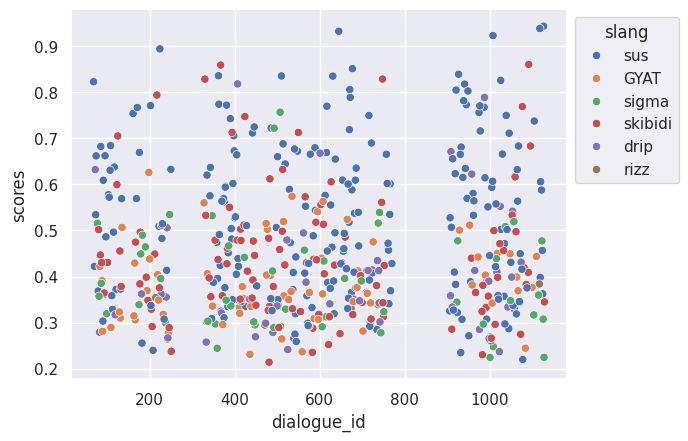

In [39]:
ax = sns.scatterplot(data = hamlet4, x = 'dialogue_id', y = 'scores', hue = 'slang')

sns.move_legend(ax, 'upper left', bbox_to_anchor = (1, 1))

Text(0.5, 1.0, "Hamlet's Aura Over Time, No Cap")

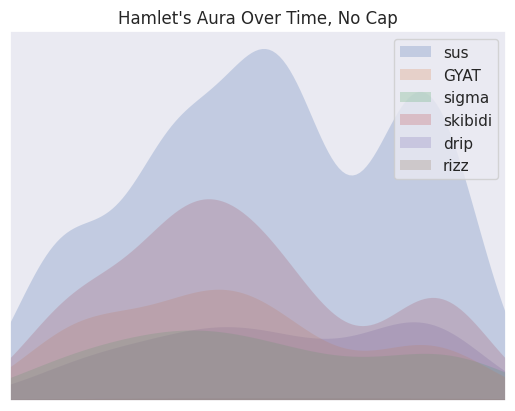

In [40]:
ax = sns.kdeplot(data = hamlet4, x = 'dialogue_id', hue = 'slang', fill = True,
                 linewidth = 0)

ax.set_xlabel(None)
ax.set_ylabel(None)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xbound([0, 1200])
ax.legend_.set_title(None)
ax.set_title("Hamlet's Aura Over Time, No Cap")

<ipython-input-41-3046148f2d1c>:3: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  ax = sns.kdeplot(data = hamlet4.filter(pl.col('slang').is_in(['sigma', 'sus', 'skibidi', 'GYAT'])),


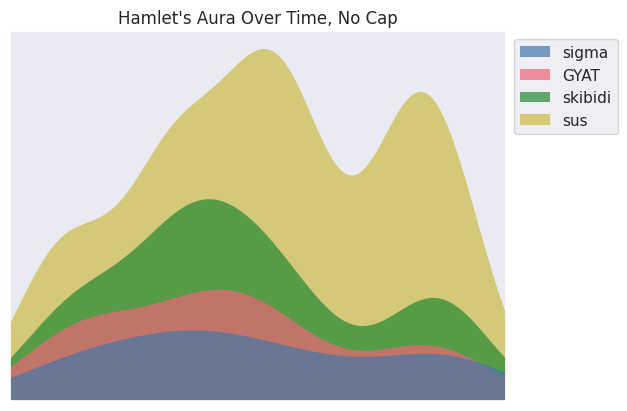

In [41]:
ptol = sns.color_palette(['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE'], 5)

ax = sns.kdeplot(data = hamlet4.filter(pl.col('slang').is_in(['sigma', 'sus', 'skibidi', 'GYAT'])),
                 x = 'dialogue_id', hue = 'slang', fill = True, alpha = 0.7,
                 linewidth = 0, palette = ptol, hue_order = ['sigma', 'GYAT', 'skibidi', 'sus'])

ax.set_xlabel(None)
ax.set_ylabel(None)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xbound([0, 1200])
ax.legend_.set_title(None)
ax.set_title("Hamlet's Aura Over Time, No Cap")

sns.move_legend(ax, 'upper left', bbox_to_anchor = (1, 1))

<Axes: xlabel='act', ylabel='scores'>

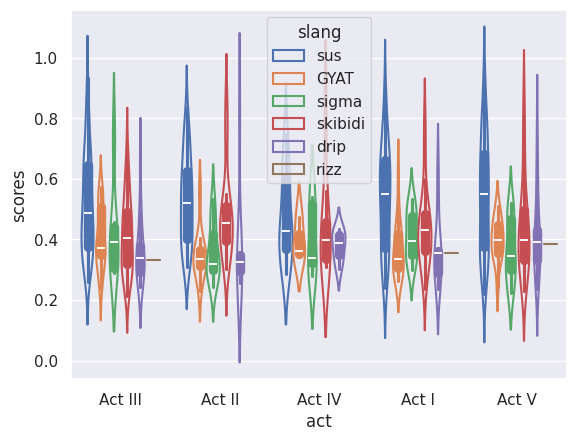

In [42]:
sns.violinplot(data = hamlet4, y = 'scores', x = 'act', hue = 'slang', fill = False)

In [43]:
# aggregate by act

time2 = hamlet4.group_by(['act', 'scene', 'slang']).len(name = 'count')

time2

act,scene,slang,count
str,str,str,u32
"""Act III""","""Scene I""","""sigma""",3
"""Act V""","""Scene II""","""drip""",13
"""Act IV""","""Scene II""","""skibidi""",2
"""Act III""","""Scene I""","""sus""",3
"""Act III""","""Scene I""","""skibidi""",7
…,…,…,…
"""Act II""","""Scene II""","""skibidi""",26
"""Act V""","""Scene II""","""rizz""",1
"""Act V""","""Scene I""","""sus""",32


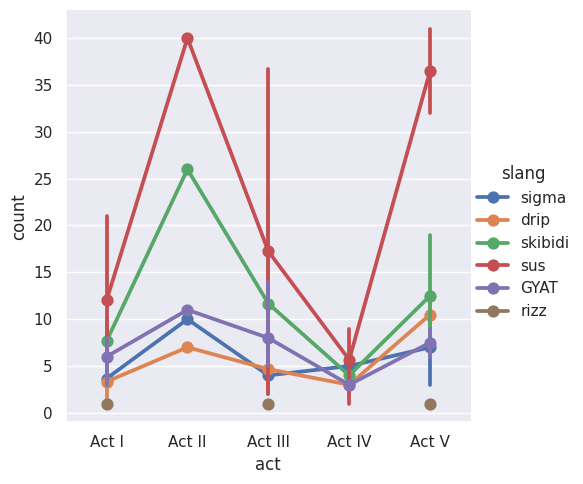

In [44]:
sns.catplot(data = time2, x = 'act', y = 'count', hue = 'slang', kind = 'point',
            order = ['Act I', 'Act II', 'Act III', 'Act IV', 'Act V'])